# Analiza głównych składowych (PCA)

*Niyaz Lapkouski gr. 5 (sr. 18:30)*

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 1. Wczytywanie i przygotowanie danych

Wykorzystujemy zbiór danych Fish Market.

Będziemy przewidywać wagę ryby (Weight) na podstawie jej wymiarów.

In [207]:
df = pd.read_csv('Fish.csv')

print("Pierwsze wiersze danych:") # brief EDA
print(df.head())
print(f"Rozmiar zbioru: {df.shape}")
print("Statystyki:")
print(df.describe())
#print(df.info())

Pierwsze wiersze danych:
  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340
Rozmiar zbioru: (159, 7)
Statystyki:
            Weight     Length1     Length2     Length3      Height       Width
count   159.000000  159.000000  159.000000  159.000000  159.000000  159.000000
mean    398.326415   26.247170   28.415723   31.227044    8.970994    4.417486
std     357.978317    9.996441   10.716328   11.610246    4.286208    1.685804
min       0.000000    7.500000    8.400000    8.800000    1.728400    1.047600
25%     120.000000   19.050000   21.000000   23.150000    5.944800    3.385650
50%     273.000000   25.200000   27.300000   29.400000    7.786000    4.248500
75%     650.0

In [208]:
y = df['Weight'].values
X = df[['Length1', 'Length2', 'Length3', 'Height', 'Width']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # splitting data

Centrujemy dane:

In [209]:
mean_train = X_train.mean(axis=0) # centering
X_train_centered = X_train - mean_train
X_test_centered = X_test - mean_train

print(X_train_centered.mean(axis=0))

[-1.42668030e-15 -7.27327210e-16  2.34982637e-15  3.70657136e-16
  1.34625469e-15]


## 2. Rozkład SVD i obliczanie wariancji

Stosujemy SVD: $A = U\Sigma V^T$. Wariancja wzdłuż każdego głównego kierunku obliczana jest jako $\text{var}_i = \frac{\sigma_i^2}{n-1}$.

In [210]:
# Rozkład SVD wycentrowanych danych
U, singular_values, Vt = np.linalg.svd(X_train_centered, full_matrices=False)

print("Rozmiary:\n",f"U: {U.shape}",f"V^t: {Vt.shape}")
print(f"Ilość singular_values: {singular_values.shape[0]}")
print(f"{singular_values}")

# Obliczanie wariancji dla każdego kierunku
# var_i = sigma_i^2 / (n - 1)
n = X_train_centered.shape[0]
variances = (singular_values ** 2) / (n - 1)

print(f"\nWariancja dla każdego głównego kierunku:")
for i, var in enumerate(variances):
    print(f"    Komponent {i+1}: {var:.4f}")

Rozmiary:
 U: (127, 5) V^t: (5, 5)
Ilość singular_values: 5
[210.6052611   35.9482482    9.42118732   4.12508612   1.83267287]

Wariancja dla każdego głównego kierunku:
    Komponent 1: 352.0204
    Komponent 2: 10.2562
    Komponent 3: 0.7044
    Komponent 4: 0.1351
    Komponent 5: 0.0267


## 3. Analiza wyjaśnianej wariancji

Określamy, ile komponentów potrzeba do wyjaśnienia 70% wariancji.

In [211]:
# Relatywny udział każdego kierunku
total_variance = variances.sum()
explained_variance_ratio = variances / total_variance # odsetki

# Wariancja kumulatywna
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Relatywny udział każdego komponentu:")
for i in range(len(explained_variance_ratio)):
    print(f"PC{i+1}: {explained_variance_ratio[i]*100:.2f}% (kumulatywnie: {cumulative_variance[i]*100:.2f}%)")

Relatywny udział każdego komponentu:
PC1: 96.94% (kumulatywnie: 96.94%)
PC2: 2.82% (kumulatywnie: 99.76%)
PC3: 0.19% (kumulatywnie: 99.96%)
PC4: 0.04% (kumulatywnie: 99.99%)
PC5: 0.01% (kumulatywnie: 100.00%)


Określamy liczbę komponentów dla 70%

In [212]:
n_components_70 = np.argmax(cumulative_variance >= 0.70) + 1
print(f"Do 70% wariancji potrzeba komponentów: {n_components_70}")
print(f"Wyjaśniają one: {cumulative_variance[n_components_70-1]*100:.2f}%")

Do 70% wariancji potrzeba komponentów: 1
Wyjaśniają one: 96.94%


Wizualizacja otrzymanych wyników:

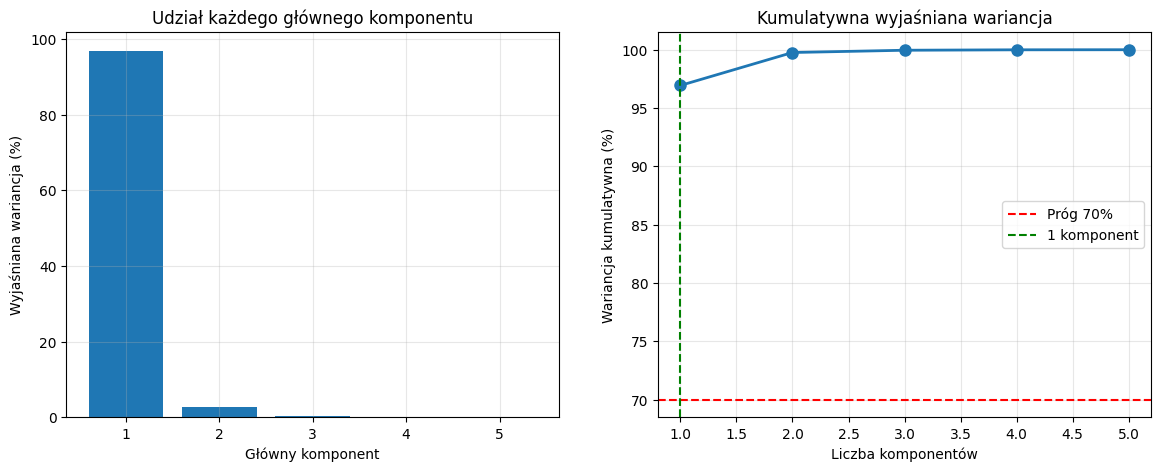

In [213]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: Relatywny udział każdego komponentu
ax1.bar(range(1, len(explained_variance_ratio)+1), explained_variance_ratio * 100)
ax1.set_xlabel('Główny komponent')
ax1.set_ylabel('Wyjaśniana wariancja (%)')
ax1.set_title('Udział każdego głównego komponentu')
ax1.grid(True, alpha=0.3)

# Wykres 2: Wariancja kumulatywna
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance * 100, 'o-', linewidth=2, markersize=8)
ax2.axhline(y=70, color='r', linestyle='--', label='Próg 70%')
ax2.axvline(x=n_components_70, color='g', linestyle='--', label=f'{n_components_70} komponent')
ax2.set_xlabel('Liczba komponentów')
ax2.set_ylabel('Wariancja kumulatywna (%)')
ax2.set_title('Kumulatywna wyjaśniana wariancja')
ax2.legend()
ax2.grid(True, alpha=0.3)

### Wniosek:
 Wszystkie 5 cech (wymiary ryby) są silnie skorelowane i faktycznie opisują jeden wymiar - 'ogólny rozmiar ryby'.

## 4. Redukcja wymiarowości

Rzutujemy dane na wybrane główne komponenty. Rzutowanie: $X_{\text{reduced}} = X_{\text{centered}} \cdot V^T_{\text{selected}}$

In [ ]:
# Wybieramy pierwsze n_components_70 (czyli 1 w naszym przypadku) wierszy z Vt (to jest V^T)
# V - to Vt.T, potrzebujemy pierwszych n_components_70 kolumn z V
V = Vt.T
V_selected = V[:, :n_components_70]

print(f"Wymiarowość V_selected: {V_selected.shape}")
print(f"Używamy {n_components_70} głównych komponentów")

# Projekcja danych treningowych
X_train_reduced = X_train_centered @ V_selected
print(f"\nWymiarowość X_train_reduced: {X_train_reduced.shape}")

# Projekcja danych testowychs
X_test_reduced = X_test_centered @ V_selected
print(f"Wymiarowość X_test_reduced: {X_test_reduced.shape}")

Wymiarowość V_selected: (5, 1)
Używamy 1 głównych komponentów

Wymiarowość X_train_reduced: (127, 1)
Wymiarowość X_test_reduced: (32, 1)


### Mamy redukcję: 5 cech → 1 cecha

## 5. Aproksymacja wielomianowa na zredukowanych danych

Tworzymy cechy wielomianowe i budujemy model metodą najmniejszych kwadratów (MNK).

In [215]:
# Tworzymy cechy wielomianowe stopnia 2
poly_degree = 2
poly = PolynomialFeatures(degree=poly_degree)

X_train_poly = poly.fit_transform(X_train_reduced)
X_test_poly = poly.transform(X_test_reduced)

print(f"Wybrany stopień wielomianu: {poly_degree}")
print(f"Wymiarowość po utworzeniu cech wielomianowych: {X_train_poly.shape}")

# MNK: rozwiązujemy X_poly @ w = y
# w = (X_poly^T @ X_poly)^{-1} @ X_poly^T @ y (pamiętamy z zadania 1)
model_reduced = LinearRegression()
model_reduced.fit(X_train_poly, y_train)

print(f"\nWspółczynniki modelu: {model_reduced.coef_}")
print(f"Wyraz wolny: {model_reduced.intercept_}")

# Predykcje
y_train_pred_reduced = model_reduced.predict(X_train_poly)
y_test_pred_reduced = model_reduced.predict(X_test_poly)

Wybrany stopień wielomianu: 2
Wymiarowość po utworzeniu cech wielomianowych: (127, 3)

Współczynniki modelu: [ 0.         16.31925479  0.10423045]
Wyraz wolny: 350.3921465807309


## 6. Model na pełnych danych (do porównania)

Budujemy model na wszystkich 5 oryginalnych cechach bez redukcji.

In [216]:
# Używamy oryginalnych danych (nie wycentrowanych, ponieważ LinearRegression sam centruje)
# Cechy wielomianowe stopnia 2 dla wszystkich 5 cech
poly_full = PolynomialFeatures(degree=2)

X_train_poly_full = poly_full.fit_transform(X_train)
X_test_poly_full = poly_full.transform(X_test)

print(f"Stopień wielomianu: 2")
print(f"Wymiarowość po utworzeniu cech wielomianowych (pełne dane): {X_train_poly_full.shape}")

# Trenowanie modelu
model_full = LinearRegression()
model_full.fit(X_train_poly_full, y_train)

# Predykcje
y_train_pred_full = model_full.predict(X_train_poly_full)
y_test_pred_full = model_full.predict(X_test_poly_full)

Stopień wielomianu: 2
Wymiarowość po utworzeniu cech wielomianowych (pełne dane): (127, 21)


## 7. Porównanie modeli

Porównujemy modele na zbiorze testowym według trzech metryk: MSE, MAE, R².

Porównanie modeli na zbiorze testowym:

             Model          MSE        MAE       R²
Zredukowany (1 PC) 20392.710622 106.558872 0.856631
    Pełny (5 cech)  4655.846663  47.039757 0.967268


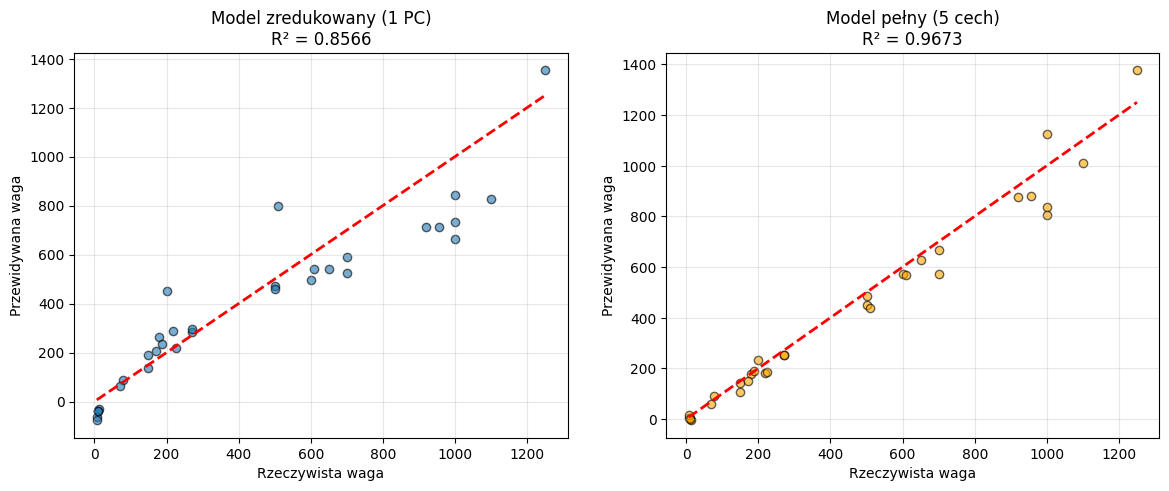

In [217]:
# Obliczamy metryki na zbiorze testowym
metrics = {
    'Model': ['Zredukowany (1 PC)', 'Pełny (5 cech)'],
    'MSE': [
        mean_squared_error(y_test, y_test_pred_reduced),
        mean_squared_error(y_test, y_test_pred_full)
    ],
    'MAE': [
        mean_absolute_error(y_test, y_test_pred_reduced),
        mean_absolute_error(y_test, y_test_pred_full)
    ],
    'R²': [
        r2_score(y_test, y_test_pred_reduced),
        r2_score(y_test, y_test_pred_full)
    ]
}

results_df = pd.DataFrame(metrics)
print("Porównanie modeli na zbiorze testowym:\n")
print(results_df.to_string(index=False))

# Porównanie wizualne
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: Predykcje modelu zredukowanego
axes[0].scatter(y_test, y_test_pred_reduced, alpha=0.6, edgecolors='k')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Rzeczywista waga')
axes[0].set_ylabel('Przewidywana waga')
axes[0].set_title(f'Model zredukowany (1 PC)\nR² = {metrics["R²"][0]:.4f}')
axes[0].grid(True, alpha=0.3)

# Wykres 2: Predykcje pełnego modelu
axes[1].scatter(y_test, y_test_pred_full, alpha=0.6, edgecolors='k', color='orange')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Rzeczywista waga')
axes[1].set_ylabel('Przewidywana waga')
axes[1].set_title(f'Model pełny (5 cech)\nR² = {metrics["R²"][1]:.4f}')
axes[1].grid(True, alpha=0.3)

## 8. Wnioski

### Analiza wariancji:
- **Pierwszy główny komponent** wyjaśnia **96.94%** całej wariancji w danych
- Oznacza to, że wszystkie 5 charakterystyk wymiarowych ryby (długości, wysokość, szerokość) są silnie skorelowane
- Faktycznie wszystkie cechy opisują jedną ukrytą właściwość - **"ogólny rozmiar ryby"**

### Redukcja wymiarowości:
- Udało się zredukować wymiarowość z **5 cech do 1** bez istotnej utraty informacji
- To upraszcza model i przyspiesza obliczenia

### Porównanie modeli:
- **Model zredukowany** (1 komponent): R² = 0.857, MAE ≈ 107
- **Model pełny** (5 cech): R² = 0.967, MAE ≈ 47

### Interpretacja:
- Model pełny daje **lepszą dokładność** (~11% różnicy w R²)
- Jednak model zredukowany pokazuje **dobre wyniki** przy użyciu tylko 1 cechy zamiast 5
- **Trade-off**: prostota vs dokładność
  - Zredukowany: prostszy, szybszy, mniejsze ryzyko przeuczenia
  - Pełny: dokładniejszy, ale bardziej złożony i wymaga więcej danych

### Wniosek praktyczny:
Dla tego zbioru danych można użyć modelu zredukowanego, jeśli potrzebna jest prostota i interpretowalność (R² = 0.86 - całkiem akceptowalne). Dla maksymalnej dokładności warto użyć wszystkich cech.

---

## Trzy trudne tematy w metodach numerycznych (imho):

1. Stabilność numeryczna algorytmów - zrozumienie, jak błędy zaokrągleń się kumulują i jak wybrać stabilną metodę
2. Rozkład QR z obrotami Householdera - geometria i algebra tych odbić jest dość złożona
